In [2]:
#Scheme 2 (Numerical  Study of a Strongly Coupled Two-scale System with Nonlinear Dispersion, Section 5.4)
#non-homogeneour Dirichlet conditions
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
set_log_active(False)


In [3]:
#Geometry 1, 2, and 3 for micro problem 

L = 1.0 #lenght of domain
W = 1.0 #width of the domain

#center of ellipse
x_0 = 0.85
y_0 = 0.75
x_1 = 0.35
y_1  =  0.1
x_2 = 0.175
y_2  =  0.8
center0 = Point(x_0, y_0)
center1 = Point(x_1, y_1)
center2 = Point(x_2, y_2)

#axis of elllipse
horizontal_semi_axis_0 = 0.1
vertical_semi_axis_0 = 0.2
horizontal_semi_axis_1 = 0.30
vertical_semi_axis_1 = 0.08
horizontal_semi_axis_2 = 0.15
vertical_semi_axis_2 = 0.15

#center and radius for geometry 2
center = Point(0.5, 0.5)
radius = 0.25


def Geometries(ny, Geometry):
    # Define domain for cell probem 
    #define geometry 1
    if Geometry == 1:
        geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
             - mshr.Ellipse(center0, horizontal_semi_axis_0, vertical_semi_axis_0, 100) - mshr.Ellipse(center1, horizontal_semi_axis_1, vertical_semi_axis_1, 100) \
               - mshr.Ellipse(center2, horizontal_semi_axis_2, vertical_semi_axis_2, 100)
    elif Geometry == 2:
        geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
             - mshr.Circle(center, radius, 100)
    elif Geometry == 3:
        geometry = mshr.Rectangle(Point(0.0, 0.0), Point(L, W)) \
                    - mshr.Rectangle(Point(0.1, 0.1), Point(0.9, 0.2))\
                    - mshr.Rectangle(Point(0.1, 0.8), Point(0.9, 0.9))
    # Build mesh
    mesh1 = mshr.generate_mesh(geometry, ny)
    return mesh1

In [71]:
Geometry = 1
aaa = Geometries(8, Geometry)
aaa

In [10]:
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
set_log_active(False)
# Define domain for cell probem and B
#mesh = Geometry1(ny)

###periodic boundary conndition
class PeriodicBoundary(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
    # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], 1)) or 
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)
    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1
            y[1] = x[1] - 1
        elif near(x[0], 1):
            y[0] = x[0] - 1
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1
PbcUnit = PeriodicBoundary() 

# Construct facet markers
def STOKE(mesh, Geometry):
    bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1) 
    for f in facets(mesh):
        mp = f.midpoint()
        if Geometry == 1:
            if ((mp[0]- x_0)/horizontal_semi_axis_0)**2 + ((mp[1]-y_0)/vertical_semi_axis_0)**2 <=1: # elllipse is marked as 5
                bndry[f] = 5
            elif ((mp[0]- x_1)/horizontal_semi_axis_1)**2 + ((mp[1]-y_1)/vertical_semi_axis_1)**2 <=1: # elllipse is marked as 5
                bndry[f] = 5
            elif ((mp[0]- x_2)/horizontal_semi_axis_2)**2 + ((mp[1]-y_2)/vertical_semi_axis_2)**2 <=1: # elllipse is marked as 5
                bndry[f] = 5 
        elif Geometry == 2:
            if mp.distance(center) <= radius: # circle
                bndry[f] = 5
        elif Geometry == 3:
            if near(mp[0], 0.1) and (0.1<=mp[1] and mp[1]<=0.2): # boundary of inner rectang is marked as 5
                bndry[f] = 5
            elif near(mp[0], 0.9) and (0.1<=mp[1] and mp[1]<=0.2): # 
                bndry[f] = 5 
            elif near(mp[0], 0.1) and (0.8<=mp[1] and mp[1]<=0.9): # 
                bndry[f] = 5
            elif near(mp[0], 0.9) and (0.8<=mp[1] and mp[1]<=0.9): # 
                bndry[f] = 5
            elif near(mp[1], 0.1) and (0.1<=mp[0] and mp[0]<=0.9): # 
                bndry[f] = 5
            elif near(mp[1], 0.2) and (0.1<=mp[0] and mp[0]<=0.9): # 
                bndry[f] = 5 
            elif near(mp[1], 0.8) and (0.1<=mp[0] and mp[0]<=0.9): # 
                bndry[f] = 5
            elif near(mp[1], 0.9) and (0.1<=mp[0] and mp[0]<=0.9): # 
                bndry[f] = 5   
  
    #define a finite element space
    P0 = VectorElement('P', mesh.ufl_cell(), 2) #  Here  we used the Taylor-Hood element, second order Lagrange basis element for each component of velocity and first order for pressure   
    P1 = FiniteElement('P', mesh.ufl_cell(), 1) #  first order lagrange element  for pressure.
    TH = P0 * P1 

    W = FunctionSpace(mesh, TH, constrained_domain = PbcUnit) # Mixed function space with periodic boundary condition in outer boundary
    BC_value_circle = Constant((0, 0)) #Boundary value on the inner circle
    bc_circle = DirichletBC(W.sub(0), BC_value_circle, bndry, 5) #Impelemntation of BC on inner circle
    
    # Collect boundary conditions
    bcs = [bc_circle]
    # Facet normal and boundary measure
    n = FacetNormal(mesh)
    I = Identity(mesh.geometry().dim())
    ds = Measure("ds", subdomain_data=bndry)
    nu = Constant(0.01)
    F = Expression(("10*(sin(2*pi*x[0])*sin(2*pi*x[1]))", '10*(sin(2*pi*x[0])*cos(2*pi*x[1]))'), degree =2)

    def stokes():
        # Define variational forms for Stokes
        def a(u,v):
            return inner(nu*grad(u), grad(v))*dx
        def b(p,v):
            return p*div(v)*dx
        def L(v):
            return inner(F, v)*dx
        # Solve the problem
        B, p = TrialFunctions(W)
        v, q = TestFunctions(W)
        w = Function(W)
        solve(a(B, v) - b(p, v) + b(q, B) == L(v), w, bcs)
        return w

    if __name__ == "__main__":
        for problem in [stokes]:
            begin("Running '%s'" % problem.__name__)

            # Call solver
            w = problem()

            # Extract solutions
            B, p = w.split()
            plt.colorbar(plot((B)))
            plt.title("$B$")
            plt.show()
            ###plot B_1
            plt.colorbar(plot((B[0])))
            plt.title("$B_1$")
            plt.xlabel('$y_1$')
            plt.ylabel('$y_2$')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.show()
             ###plot B_2
            plt.colorbar(plot((B[1])))
            plt.title("$B_2$")
            plt.xlabel('$y_1$')
            plt.ylabel('$y_2$')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.show()
            plt.colorbar(plot((p)))
            plt.title("$P$")
            plt.show()
            end()
    return B            



In [64]:
#Precomputing# auxuliary problem (Input: a vector of p values, B, mesh; out put: entries of D_star matrix )
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt

def D_star(p, B_y, mesh):
    #### Defining D(y) matirx with D_11, D_12, D_21, D_22 component
    D_11 = Expression('2 +sin(pi*x[0])*sin(pi*x[1])', degree =1) #fast diffusion case 
    D_12 = Constant(0)
    D_21 = Constant(0)
    D_22 = Expression('2 + sin(2*pi*x[0])', degree =1) #fast diffusion case 
    D = as_matrix([[D_11, D_12],[D_21, D_22]])
    e_1 = as_vector([1, 0])
    e_2 = as_vector([0, 1])
    P2 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R2 = FiniteElement("Real", mesh.ufl_cell(), 0)
    area = assemble(Constant(1.0)*dx(mesh)) #Area of the domain
    function_space = FunctionSpace(mesh, P2 * R2, constrained_domain = PbcUnit)
    D_HOM_11 = []
    D_HOM_12 = []
    D_HOM_21 = []
    D_HOM_22 = []
    for i in range(number_of_points):
        (w1, c) = TrialFunction(function_space)
        (v, d) = TestFunction(function_space) 
        a_1 = dot(D*grad(w1), grad(v))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w1, grad(v))*dx(domain=mesh) + c*v*dx(domain=mesh) + w1*d*dx(domain=mesh)
        L_1 =   -dot(D*e_1, grad(v))*dx(domain=mesh) 
        W1 = Function(function_space)
        solve(a_1 == L_1, W1)
        (w1, c) = W1.split()
        if i == 57:
            plt.colorbar(plot(w1))
            plt.show()
        (w2, c1) = TrialFunction(function_space)
        (v1, d1) = TestFunction(function_space)
        a_2 = dot(D*grad(w2), grad(v1))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w2, grad(v1))*dx(domain=mesh) + c1*v1*dx(domain=mesh) + w2*d1*dx(domain=mesh)
        L_2 = - dot(D*e_2, grad(v1))*dx(domain=mesh)
        
        # Compute cell solution w_2
        W2 = Function(function_space)
        solve(a_2 == L_2, W2)
        (w2, c1) = W2.split()
        
        #ploting w_1
        fig = plt.figure(dpi=1000)
        plt.colorbar(plot((w1), mode = 'color', vmin=-0.22, vmax=0.21))
        plt.set_cmap('coolwarm') 
        fontsize = 15
        fontweight = 'normal'
        fontproperties = {'weight' : fontweight, 'size' : fontsize}
        plt.xlabel('$y_1$', fontsize= fontsize, fontweight=fontweight)
        plt.ylabel(r'$y_2$', fontsize= fontsize, fontweight=fontweight)
        #plt.title('$B_2$', fontsize = 15)
        #plt.axis([-10.005, 10.005, 1.5, 2.1])
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(r'$w_1$')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()
        
        #compute D^*
        D_hom_11 =  (1/area)*(assemble(dot(D_11, (1 + w1.dx(0)))*dx(domain=mesh)) + assemble(dot(D_12,  w1.dx(1))*dx(domain=mesh)))
        D_hom_12 =  (1/area)*(assemble(dot(D_11, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_12, (1+ w2.dx(1)))*dx(domain=mesh)))
        D_hom_21 =  (1/area)*(assemble(dot(D_22, w1.dx(1))*dx(domain=mesh)) + assemble(dot(D_21, (1 + w1.dx(0)))*dx(domain=mesh)))
        D_hom_22 =  (1/area)*(assemble(dot(D_21, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_22, (1 + w2.dx(1)))*dx(domain=mesh))) 
        D_HOM_11.append(D_hom_11) #store D_hom_11 value for each vertix and store them in the lise D_HOM_11. 
        D_HOM_12.append(D_hom_12)  #store D_hom_12 value for each vertix and store them in the lise D_HOM_12. 
        D_HOM_21.append(D_hom_21)  #store D_hom_21 value for each vertix and store them in the lise D_HOM_21. 
        D_HOM_22.append(D_hom_22)  #store D_hom_22 value for each vertix and store them in the lise D_HOM_22.
    return D_HOM_11, D_HOM_12, D_HOM_21, D_HOM_22

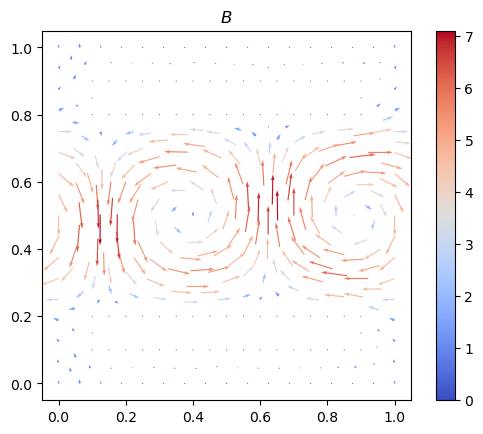

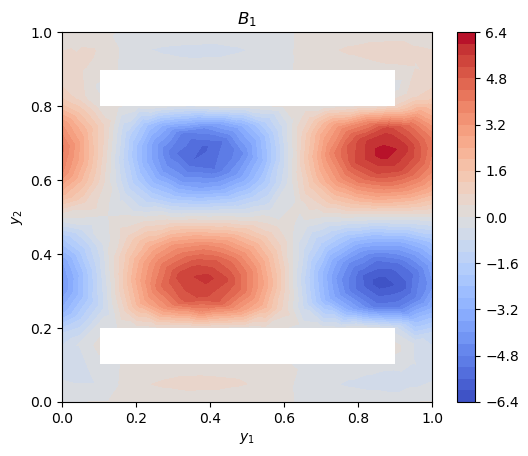

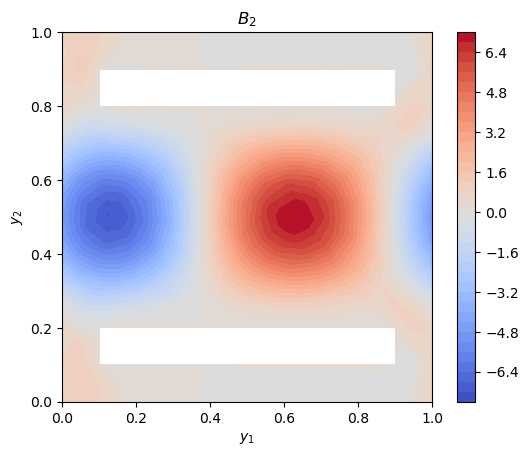

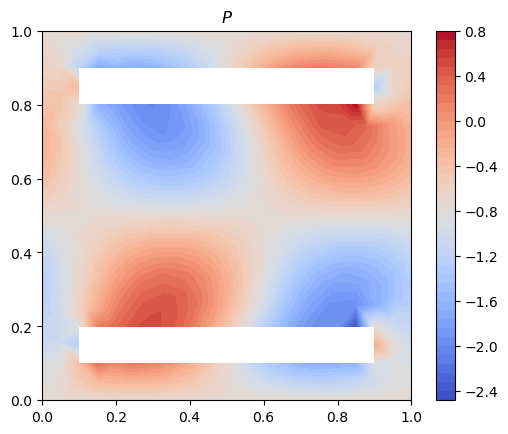

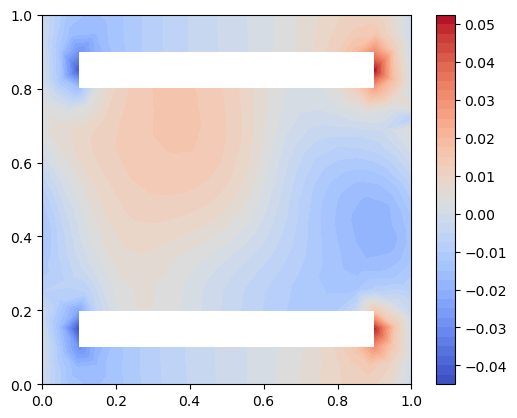

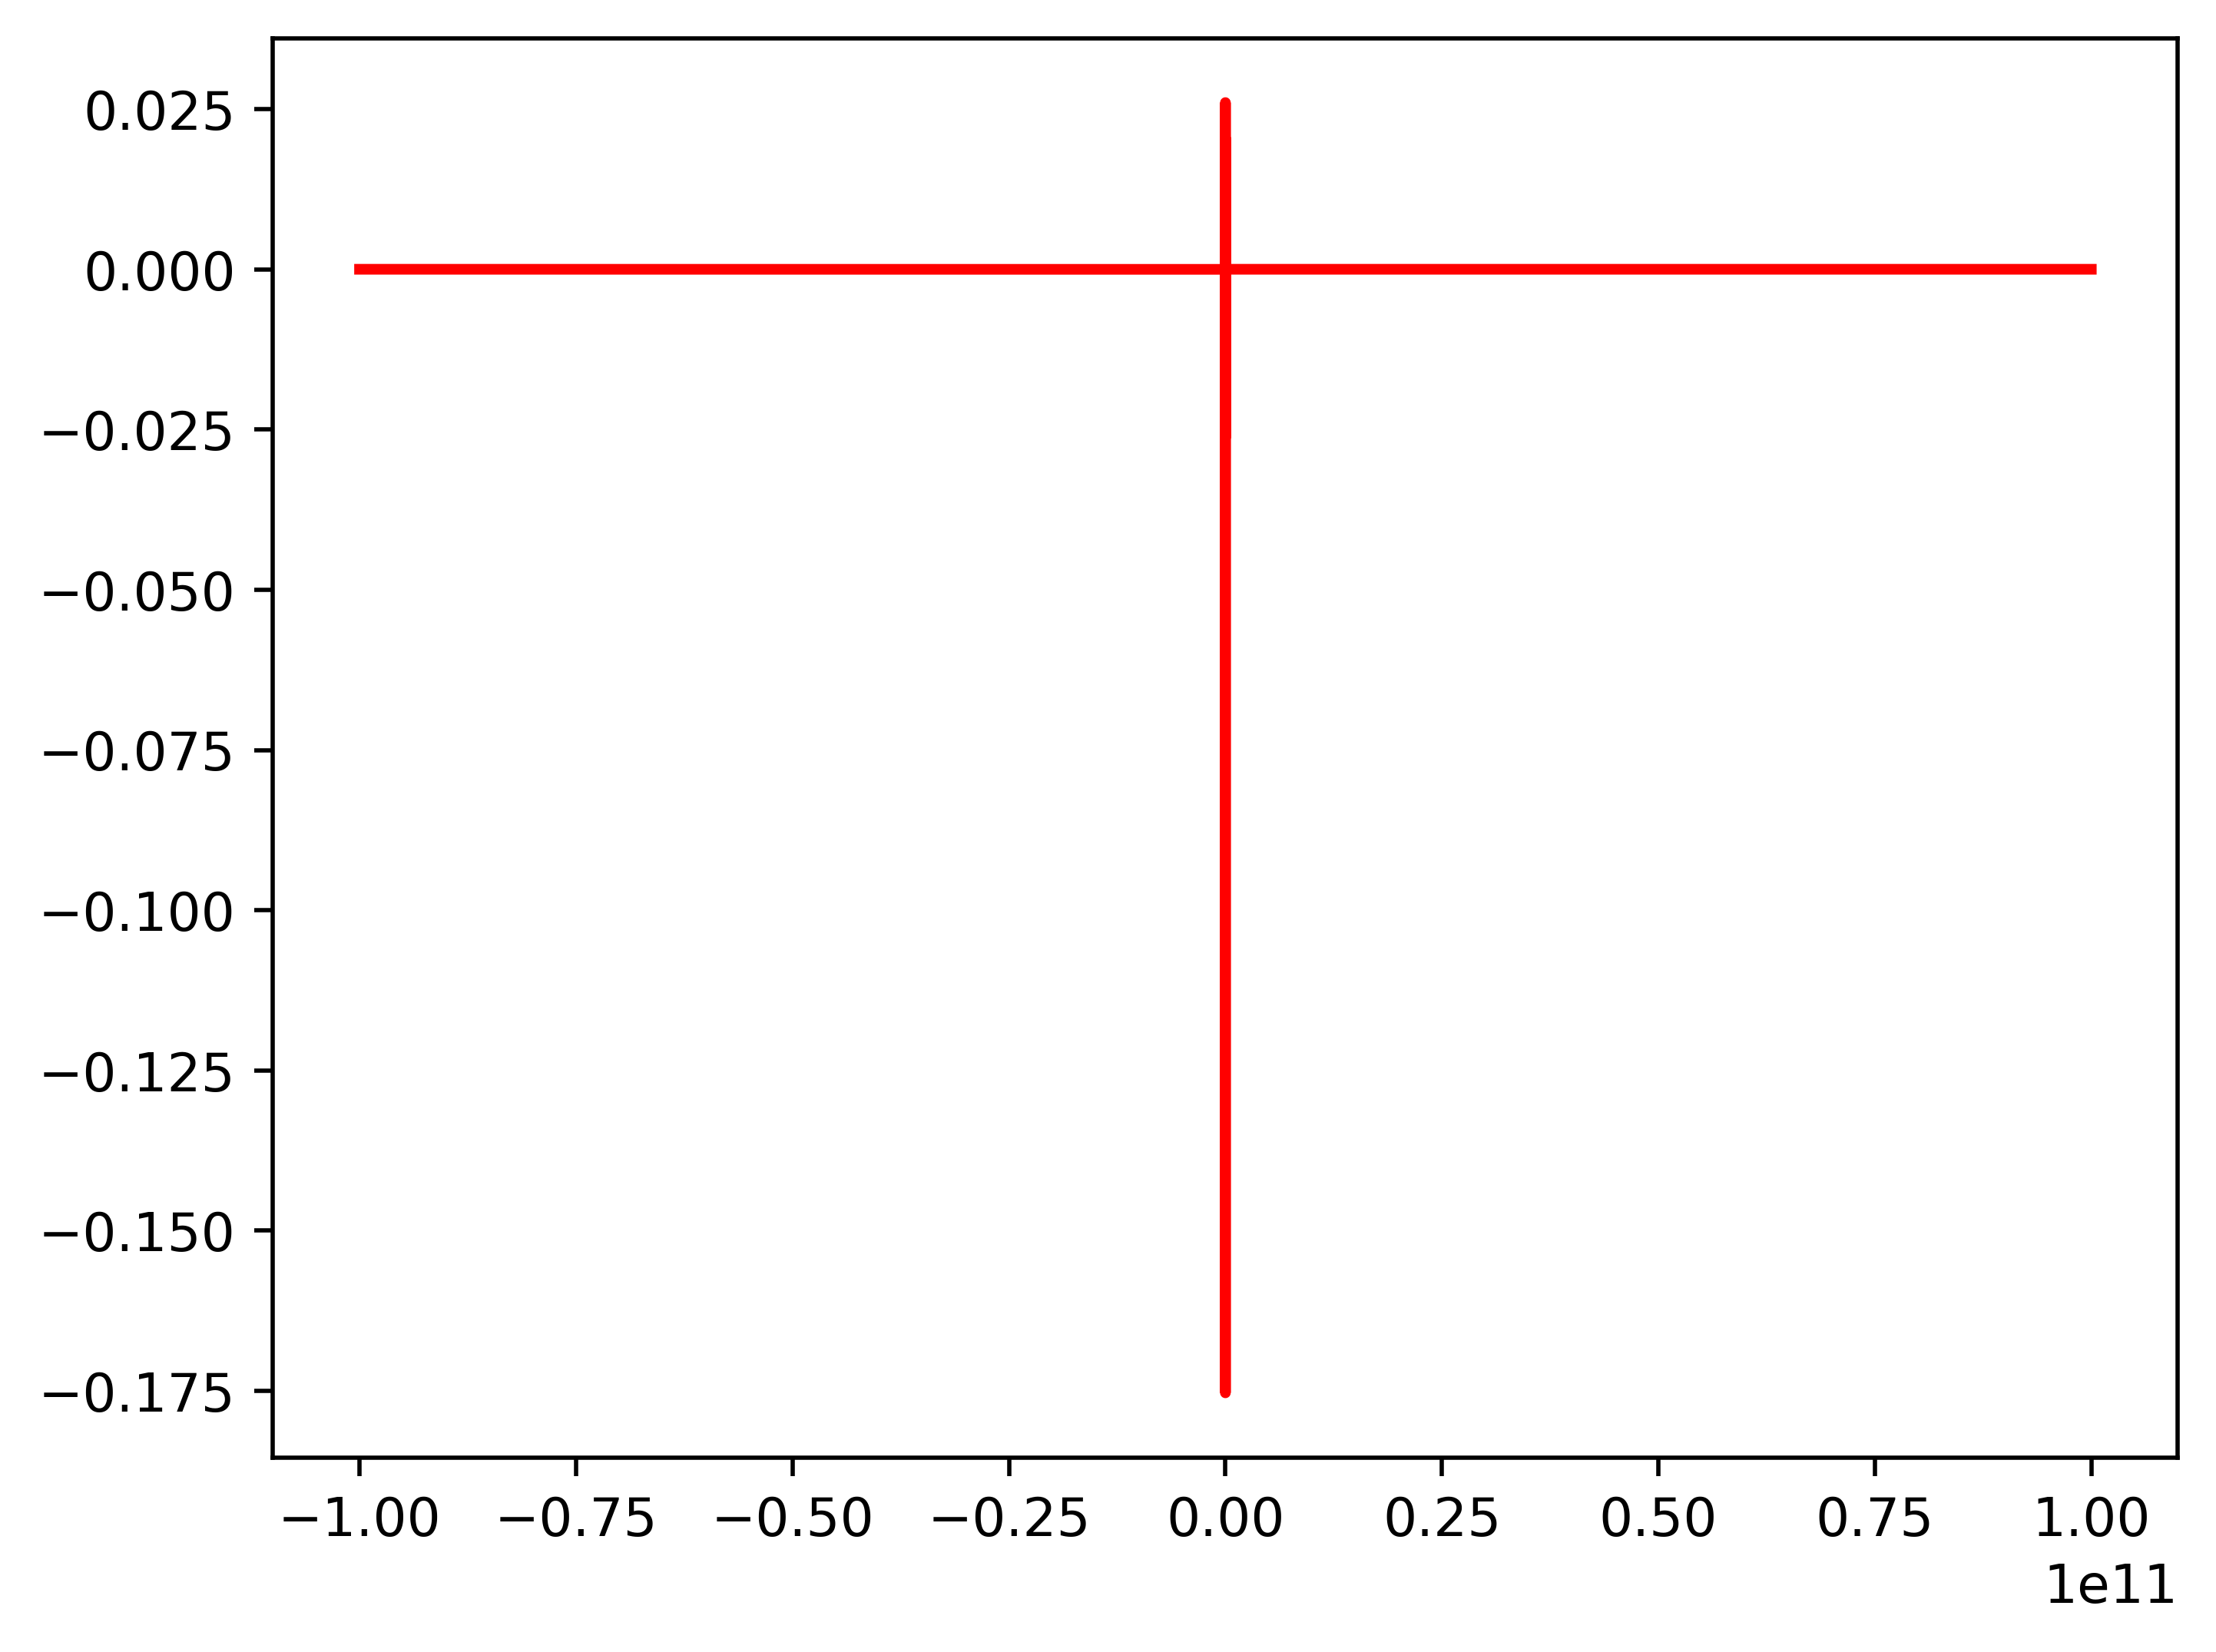

computation time is 11.273592948913574 seconds


In [19]:
import time
start_time = time.time()
#choose the geometry and ny
Geometry = 3
ny = 15
#construct a vector containing the values of p
x1 = -np.logspace(0, 10, 50, endpoint=True)[::-1]*10
x2 = np.linspace(x1[-1], -x1[-1], 101)
x3 = np.logspace(0, 10, 50, endpoint=True)*10
p_i = np.concatenate((x1, x2, x3), axis=0)
XX = np.sort(p_i)

#total numbers of p
number_of_points = len(XX)

#mesh on the chosen geometry
mesh = Geometries(ny, Geometry)

#solve the stoke problme on desired mesh and 
B = STOKE(mesh, Geometry)
D_hom = D_star(XX, B, mesh)
fig = plt.figure(dpi=500)
plt.plot(XX, np.array(D_hom[2]), 'r-',  linewidth=2)
#plt.plot(X, np.array(D_star_geometry_2[0]), 'g--',  linewidth=2)
#plt.xlim(np.min(P_i), np.max(P_i))
#plt.xlim(-20,20)
plt.show()
end_time = time.time() 
computation_time = (end_time-start_time)
print('computation time is', computation_time, 'seconds')

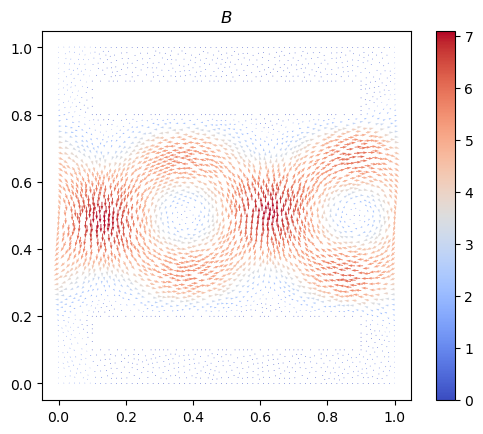

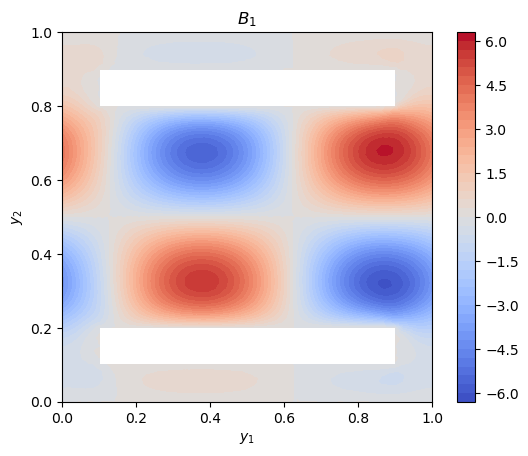

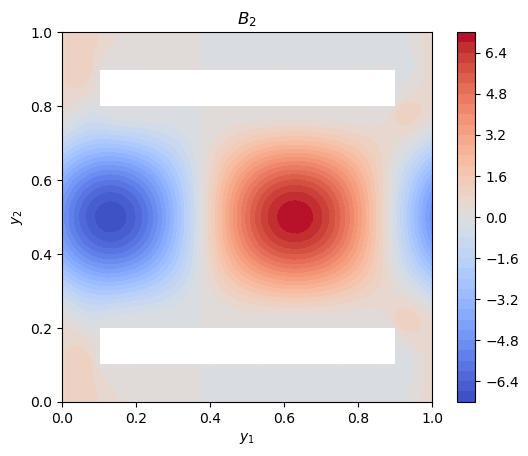

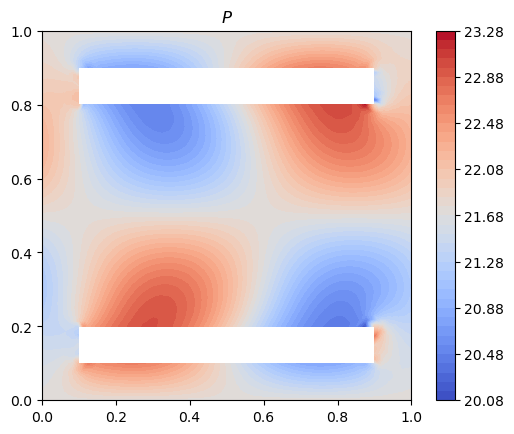

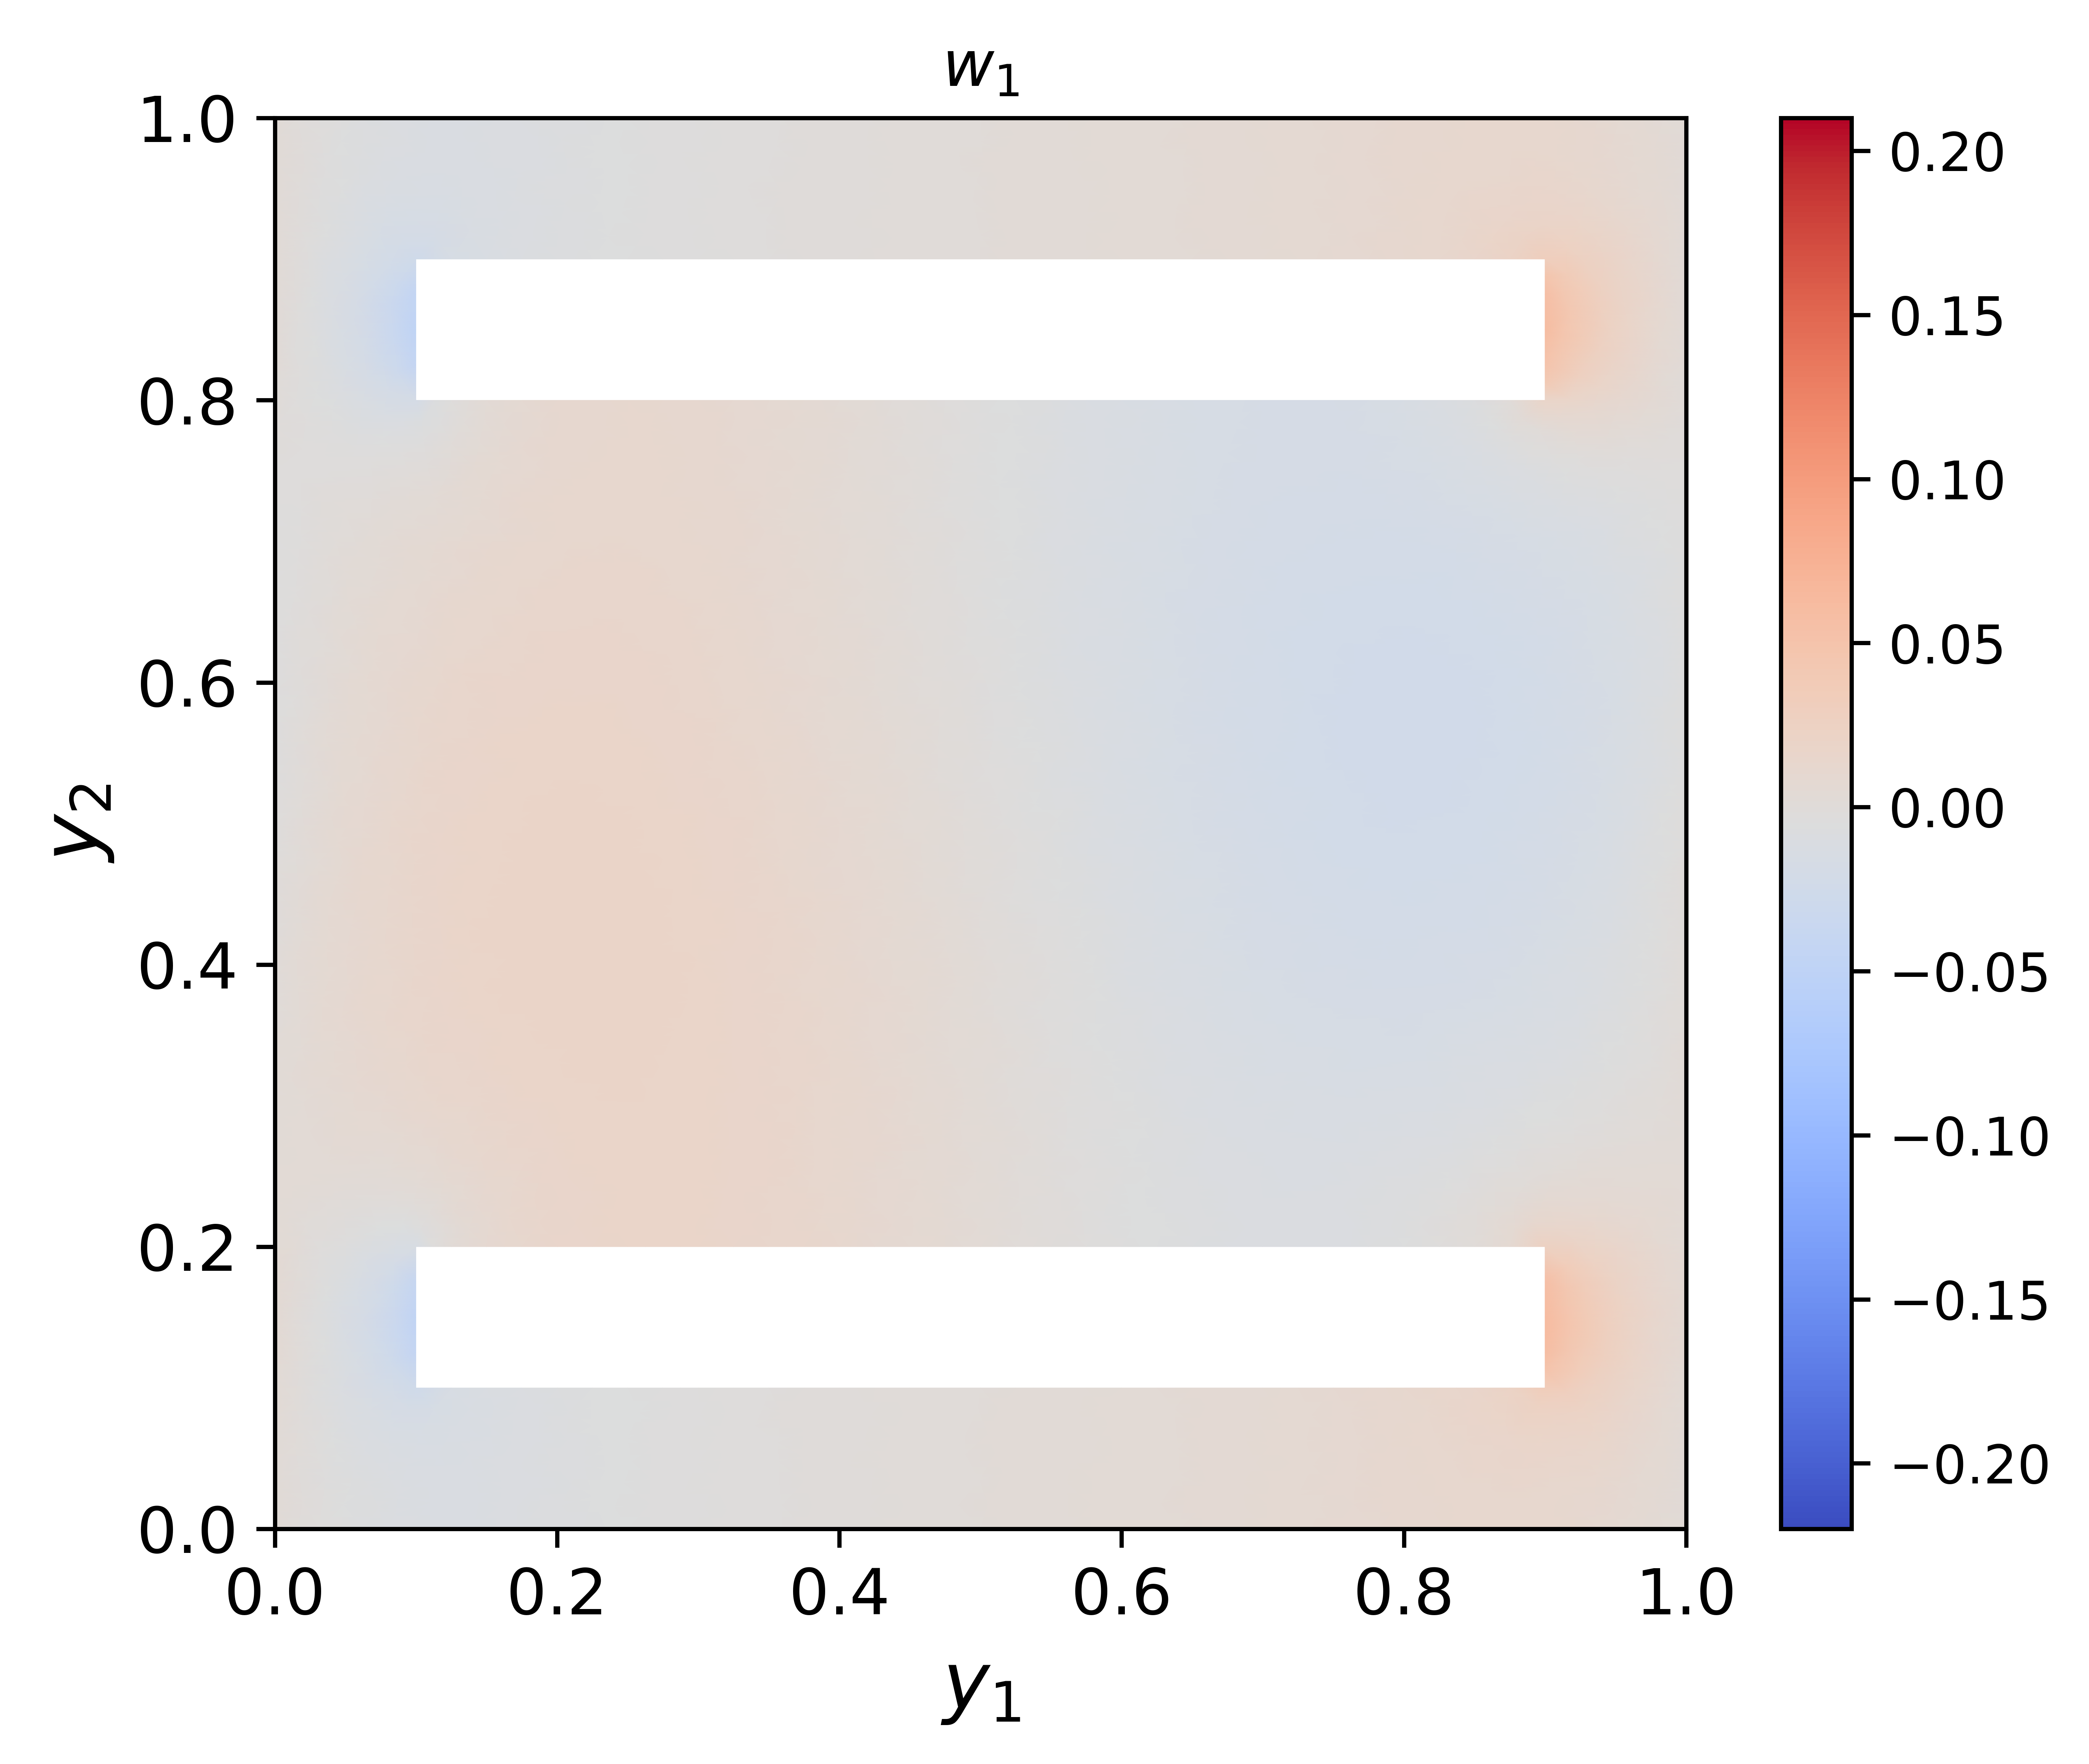

In [67]:
Geometry = 3
ny = 50
#construct a vector containing the values of p
x1 = -np.logspace(0, 10, 50, endpoint=True)[::-1]*10
x2 = np.linspace(x1[-1], -x1[-1], 101)
x3 = np.logspace(0, 10, 50, endpoint=True)*10
p_i = np.concatenate((x1, x2, x3), axis=0)
XX = np.sort(p_i)
XX = [1]

#total numbers of p
number_of_points = len(XX)

#mesh on the chosen geometry
mesh = Geometries(ny, Geometry)

#solve the stoke problme on desired mesh and 
B = STOKE(mesh, Geometry)
D_hom = D_star(XX, B, mesh)

H= 0.04563404035713862
number of vetrix= 2500
No of degree of freedom= 2500


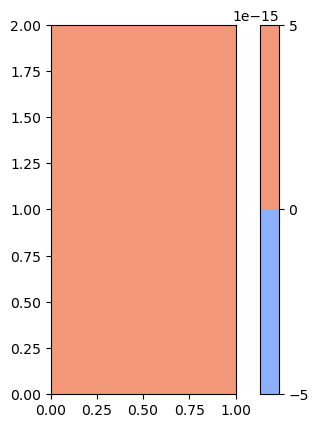

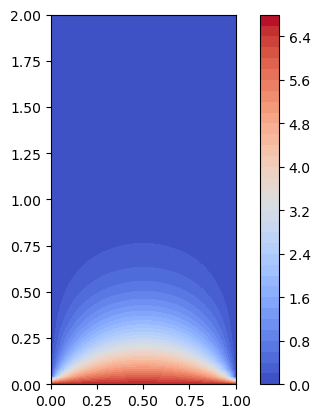

computation time= 29.267173051834106 seconds


In [89]:
#for non-homogeneous boundary condition(trial case). 

#Method2 Precomputing
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import time
U_scheme_2_pre = []
#for i in range(5):
start_time = time.time()
x_in = 0 
x_end = 1 
y_in = 0
y_end = 2
nx = 50 #total nodes in x and y directions for macro domain (Omega)
xaxis = np.linspace(x_in, x_end, nx)
yaxis = np.linspace(y_in, y_end, nx)
X, Y = np.meshgrid(xaxis, yaxis)
T = 2 #
M = 50 # number of time steps (i.e., M+1 time nodes )
dt = T/M
#u_in  = Constant(1.0) #intitlal iteration function 
#u_in =  Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
#u_in =  Expression("10*(x[1] < 0.01)", degree =2)
u_in = Constant(0.0)
#u_in = Expression("10*(sin(2*pi*x[0]))", degree =2)
#f = Expression("1000*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
f = Constant(0.0)
#f = Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))", degree =2)
#f = Expression("2 + (cos(2*pi*x[0]*t)*sin(2*pi*x[1]*t))", t=0, degree =2) #time dependent right hand side
#f = Expression("exp(-10*t*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))", t=0,  degree =2)
#f = Constant(1)
###########
Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
print('H=', Mesh.hmax() )
number_of_vertices = Mesh.num_vertices()
print('number of vetrix=', number_of_vertices )
V =  FunctionSpace(Mesh, 'Lagrange', 1) # finite element space with lagrange element of degree 1
print('No of degree of freedom=', V.dim())
u_n = interpolate(u_in, V) #interpolation of initial iteration function on finite element space
#u_n = u_0 #initial condition for each iteration 
U_0 = u_n.compute_vertex_values(Mesh) # list of the iterpolated values of u_0
#U_0_time = [U_0] # vertex values for each time step after  iterpolation the initial iteration function 
plt.colorbar(plot(u_n))
plt.show()
beta = 10
u_L =  Constant(0.0)
u_R =  Constant(0.0)
u_T =  Constant(0.0)
u_B =  Expression('beta*(t/(1+t))',  beta=beta, t=0, degree = 2)

def boundary_L(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[0], 0, tol)

def boundary_R(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[0], 1, tol)

def boundary_T(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[1], 2, tol)

def boundary_B(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[1], 0, tol)

bc_L = DirichletBC(V, u_L, boundary_L)
bc_R = DirichletBC(V, u_R, boundary_R) # zero Dirichlet boundary condition
bc_T = DirichletBC(V, u_T, boundary_T)
bc_B = DirichletBC(V, u_B, boundary_B)
bc = [bc_L, bc_R, bc_T, bc_B]
def G(u):
    return 1- 2*u
#def G(u):
#    return 1/(0.0001 + abs(1-2*u))
UU_T =[]
#UU_T.append(UU_0)
#print(UU_T)
UU_store = []
u_store= []
t = 0
###Store value of D^* corresponding to some sapce point 
D_11_x_pre = []
D_12_x_pre = []
D_21_x_pre = []
D_22_x_pre = []
for j in range(M):

    D_INTERPOLATE_11 = []
    D_INTERPOLATE_12 = []
    D_INTERPOLATE_21 = []
    D_INTERPOLATE_22 = []
    for i in range(number_of_vertices):
        #print(U_0[i])
        D_interpolate_11 = np.interp(G(U_0[i]), XX, D_hom[0])
        #print('D_11=', D_interpolate_11)
        D_interpolate_12 = np.interp(G(U_0[i]), XX, D_hom[1])
        D_interpolate_21 = np.interp(G(U_0[i]), XX, D_hom[2])
        D_interpolate_22 = np.interp(G(U_0[i]), XX, D_hom[3])
        D_INTERPOLATE_11.append(D_interpolate_11) 
        D_INTERPOLATE_12.append(D_interpolate_12) 
        D_INTERPOLATE_21.append(D_interpolate_21) 
        D_INTERPOLATE_22.append(D_interpolate_22)   
    d2v = dof_to_vertex_map(V) #A map that maps the dof to vetrix
    #print('number_of_vertices=', number_of_vertices)
    #print('number of vetrix in interpolated=', D_INTERPOLATE_11)
    #print(D_INTERPOLATE_11[int(nx/2*5)])
    # list of Vertex_values_D_11 in a way that FEniCS can define a fenics function from the discrete data of D_HOM_11, D_HOM_12,D_HOM_21, D_HOM_22 
    Vertex_values_D_11 = [D_INTERPOLATE_11[d2v[i]] for i in range(number_of_vertices)]   
    Vertex_values_D_12 = [D_INTERPOLATE_12[d2v[i]] for i in range(number_of_vertices)]
    Vertex_values_D_21 = [D_INTERPOLATE_21[d2v[i]] for i in range(number_of_vertices)]
    Vertex_values_D_22 = [D_INTERPOLATE_22[d2v[i]] for i in range(number_of_vertices)]
    
    ###initializing the each component of  D^* to a  function (componenetwise) in function space V
    D_star_11 = Function(V)
    D_star_12 = Function(V)
    D_star_21 = Function(V)
    D_star_22 = Function(V)
    
    ###assigning the discrete calculated values Vertex_values_D_11 to a function D_star_11 function. Similar for other components.
    D_star_11.vector()[:] = Vertex_values_D_11
    D_star_12.vector()[:] = Vertex_values_D_12
    D_star_21.vector()[:] = Vertex_values_D_21
    D_star_22.vector()[:] = Vertex_values_D_22 
    
    #construct a matrix from the component. we will use this mattrix D_star_k_plus_1 in macro problem.   
    D_star_k_plus_1 = as_matrix([[D_star_11,  D_star_12],[ D_star_21,  D_star_22]])
    D_11_x_pre.append(D_star_k_plus_1[0, 0].compute_vertex_values(Mesh)[int(nx/2*9)])
    D_12_x_pre.append(D_star_k_plus_1[0, 1].compute_vertex_values(Mesh)[int(nx/2*9)])
    D_21_x_pre.append(D_star_k_plus_1[1, 0].compute_vertex_values(Mesh)[int(nx/2*9)])
    D_22_x_pre.append(D_star_k_plus_1[1, 1].compute_vertex_values(Mesh)[int(nx/2*9)])
    
    #print(D_11_x_pre)
    t = t + dt
    #print(t)
    #f.t = t
    u = TrialFunction(V)
    v = TestFunction(V)
    #F = u*v*dx + dt*dot(D_star_k_plus_1_time[j]*grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
    F = u*v*dx + dt*dot(D_star_k_plus_1*grad(u), grad(v))*dx(domain=Mesh) - (u_n + dt*f)*v*dx(domain=Mesh) 
    a, L = lhs(F), rhs(F)
    u = Function(V)
    #t = t +dt
    solve(a == L, u, bc)
    plt.set_cmap('coolwarm')  #cmap->Dark2, coolwarm, jet
    #plt.colorbar(plot(u))
    #plt.show()
    u_B.t = t
    UU_store.append(u)#store each time step solution u in UU_store list
    #print('solution for time node=', UU_store[0].compute_vertex_values(Mesh))
    #error = errornorm(u, UU_store[j+1], norm_type='L2') # compute error between two consecutive iteration solution for each time step
    #print('Error=', error)
    #Error.append(error**2)
    vertex_values_u = u.compute_vertex_values(Mesh) #compute the vertex value for each time step solution
    #print(vertex_values_u)
    u_store.append(vertex_values_u) #store the vertex values solution in u_store list
    u_n = u.copy() #assign the computed solution to a new u_n  
    U_0 =  vertex_values_u.copy()
    #print(U_0)   
plt.colorbar(plot(u))
plt.show() 
#triang = tri.Triangulation(*Mesh.coordinates().reshape((-1, 2)).T,
#                           triangles=Mesh.cells())
#Z = u.compute_vertex_values(Mesh) 
#levels = np.linspace(0,np.max(Z),30)
#plt.tricontourf(triang, Z,  levels, cmap='coolwarm')
#plt.tricontourf(triang, Z,  levels, cmap='coolwarm')
#plt.colorbar()
#plt.show()        
        
U_scheme_2_pre.append(UU_store) 
end_time = time.time()
print('computation time=', (end_time - start_time), 'seconds')

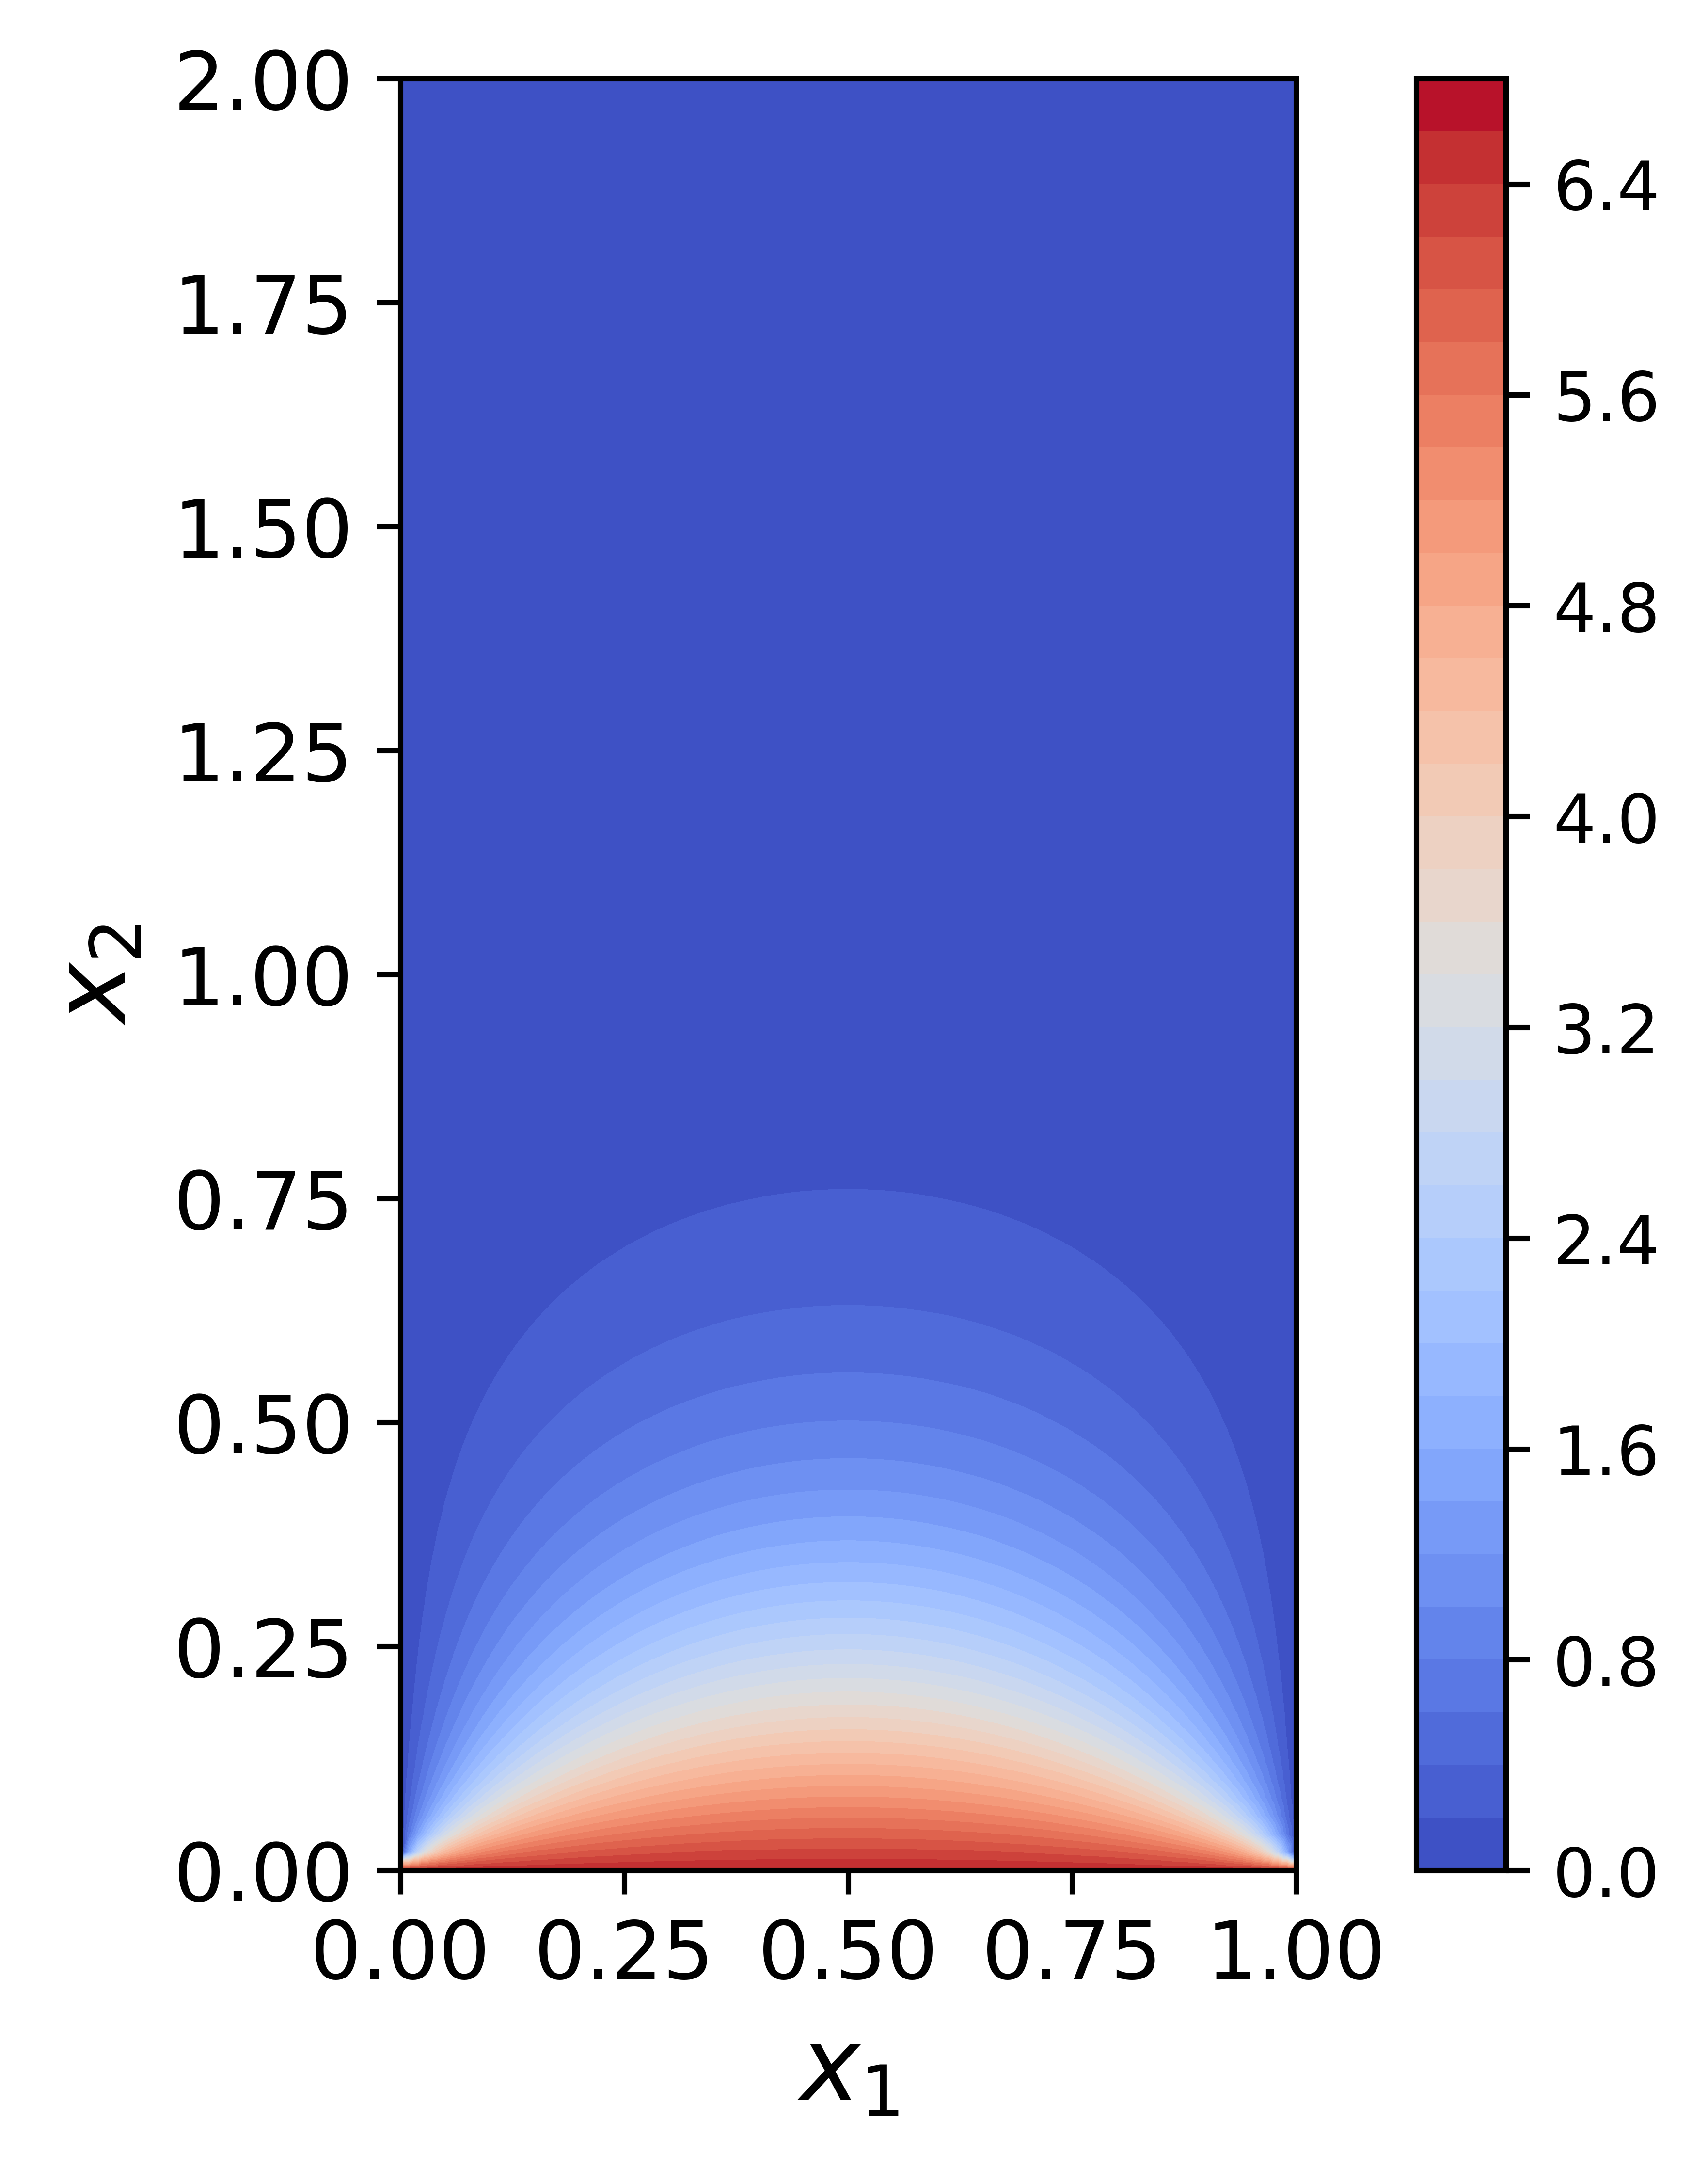

In [84]:
fig = plt.figure(dpi=1000)
plt.colorbar(plot(u))
fontsize = 15
fontweight = 'normal'
fontproperties = {'weight' : fontweight, 'size' : fontsize}
#plt.legend([r"Geometry 1",r"Geometry 2"], loc='upper right', frameon=False) # loc='upper left', frameon=False
#plt.grid()
plt.xlabel('$x_1$', fontsize= fontsize, fontweight=fontweight)
plt.ylabel(r'$x_2$', fontsize= fontsize, fontweight=fontweight)
#plt.title('$B_2$', fontsize = 15)
#plt.axis([-10.005, 10.005, 1.5, 2.1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlim(0, 1)
#plt.ylim(0, 2)
#plt.savefig('B2_geometry1.png')
plt.show()